In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import sklearn as sklearn
import math as math
import pandas as pd
import itertools
import seaborn as sn
import random
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from stability_function import*
from score import*
from cross_validation import*

In [2]:
df = pd.read_csv ('CleanVariables_SZOnly.csv',sep=',') #Import data as dataframe
X = df.iloc[:,1:].to_numpy() #Make an array with only the features we need 


# Choose the variables & Choose the number of clusters

### Correlation on the data

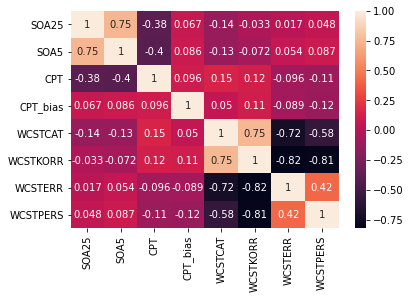

In [3]:
'''
We compute the correlation matrix of the features to check which ones are highly correlated and can be dropped.
To do so, we use the function corr()
'''
corrMatrix= df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
corrmatrix=np.corrcoef(X.astype(float).T)

We see that the features divides it self in 4 big groups : [0,1], 2,3,[4,5,6]. This is accurate since the data represents the variables of the test. 

In [4]:
# Kmeans with norm L1 with 2 clusters :  
from mlinsights.mlmodel import KMeansL1L2

Kmeans_L1 = KMeansL1L2(2, norm = 'L1')
model = Kmeans_L1.fit(X)
label = model.predict(X)

In [5]:
#EM with Gaussian Mixture : 
clf = mixture.GaussianMixture(n_components=3, covariance_type="full").fit(X)
pred=clf.predict(X)


### Choose the variables depending on Silhouette and Davies Bouldin scores

In [6]:
# We found out that the features are divided into 4 groups of highly correlated variables. 
# In each group, we select one variable to represent the group. This means we will compute the clustering only on 4 variables.
Variables = [np.array([0,1]),2,3,np.array([4,5,6,7])] 

In [7]:
#Call the function for the two methods that we selected : 
score_EM,subset = numbercluster_select(X,'EM', Variables, 11) 
score_Kmean_L1,_  = numbercluster_select(X,'Kmeans_L1', Variables, 11)

In [51]:
print('For EM')
Best_nb_cluster_db_score_EM,Best_nb_cluster_sil_score_EM,best_nb_cl_db_EM,best_nb_cl_sil_EM = findbest_score (score_EM)
print ("Best db Score:", Best_nb_cluster_db_score_EM, "Number of cluster for this score:", best_nb_cl_db_EM+2)
print ("Best silhouette Score:", Best_nb_cluster_sil_score_EM,"Number of cluster for this score:", best_nb_cl_sil_EM+2)

print('For K_means wiht l1 norm')
Best_nb_cluster_db_score_L1,Best_nb_cluster_sil_score_L1,best_nb_cl_db_L1,best_nb_cl_sil_L1 = findbest_score (score_Kmean_L1)
print ("Best db Score:", Best_nb_cluster_db_score_L1, "Number of cluster for this score:", best_nb_cl_db_L1 + 2)
print ("Best silhouette Score:", Best_nb_cluster_sil_score_L1,"Number of cluster for this score:", best_nb_cl_sil_L1+2)


For EM
Best db Score: 1.2807882179400347 Number of cluster for this score: 3
Best silhouette Score: 0.24683666789193812 Number of cluster for this score: 3
For K_means wiht l1 norm
Best db Score: 1.2933742765642364 Number of cluster for this score: 3
Best silhouette Score: 0.22820934737612603 Number of cluster for this score: 3


In [9]:
#We obtain that the best scores are for the EM algorithm with 3 clusters.
#Now, we look for which subset of features we get the best score. 
#We will do that manually: 
print("What index: ") 
print( score_EM[best_nb_cl_sil_EM])
print(score_Kmean_L1[best_nb_cl_sil_L1])

What index: 
[[1.40964194 0.23356333]
 [1.35681754 0.24013478]
 [1.86809097 0.13368301]
 [1.32544507 0.24683667]
 [1.63992497 0.18365142]
 [1.62559982 0.17626498]
 [1.58441086 0.18247163]
 [1.44397328 0.21883625]]
[[1.79138345 0.2073384 ]
 [1.7126504  0.22222895]
 [1.81333103 0.20828827]
 [1.76307547 0.20588808]
 [1.75405578 0.20474467]
 [1.65314379 0.22138925]
 [1.77348537 0.20618239]
 [1.6179188  0.22820935]]


### Clinical accuracy

We aww that the silhouette and DB scores are better for the variable 5('WCSTKORR ') but we decided to choose the variable ('WCSTPERS') because clinically (as discussed with the Lab), it is a more significant variable.

# Accuracy of the method

### Stability of method

In [10]:
#Take our variable selection
X_res1=X[:,[0,2,3,7]]
f,index_cl_change,pred1=stability(100,3,X_res1,'EM')

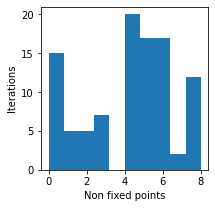

In [11]:
#plot the stability for EM
fig = plt.figure(figsize=(3, 3))
plt.xlabel("Non fixed points")
plt.ylabel("Iterations")
plt.hist(f)
plt.show()



In [13]:
Kmeans_L1 = KMeansL1L2(3, norm = 'L1')
model1=Kmeans_L1.fit(X_res1)
f=stability(100,3,X_res1,'Kmeans_L1')

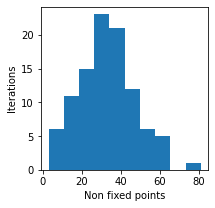

In [14]:
#plot the stability for Kmeans with l1-norm
fig = plt.figure(figsize=(3, 3))
plt.xlabel("Non fixed points")
plt.ylabel("Iterations")
plt.hist(f)
plt.show()

<IPython.core.display.Javascript object>


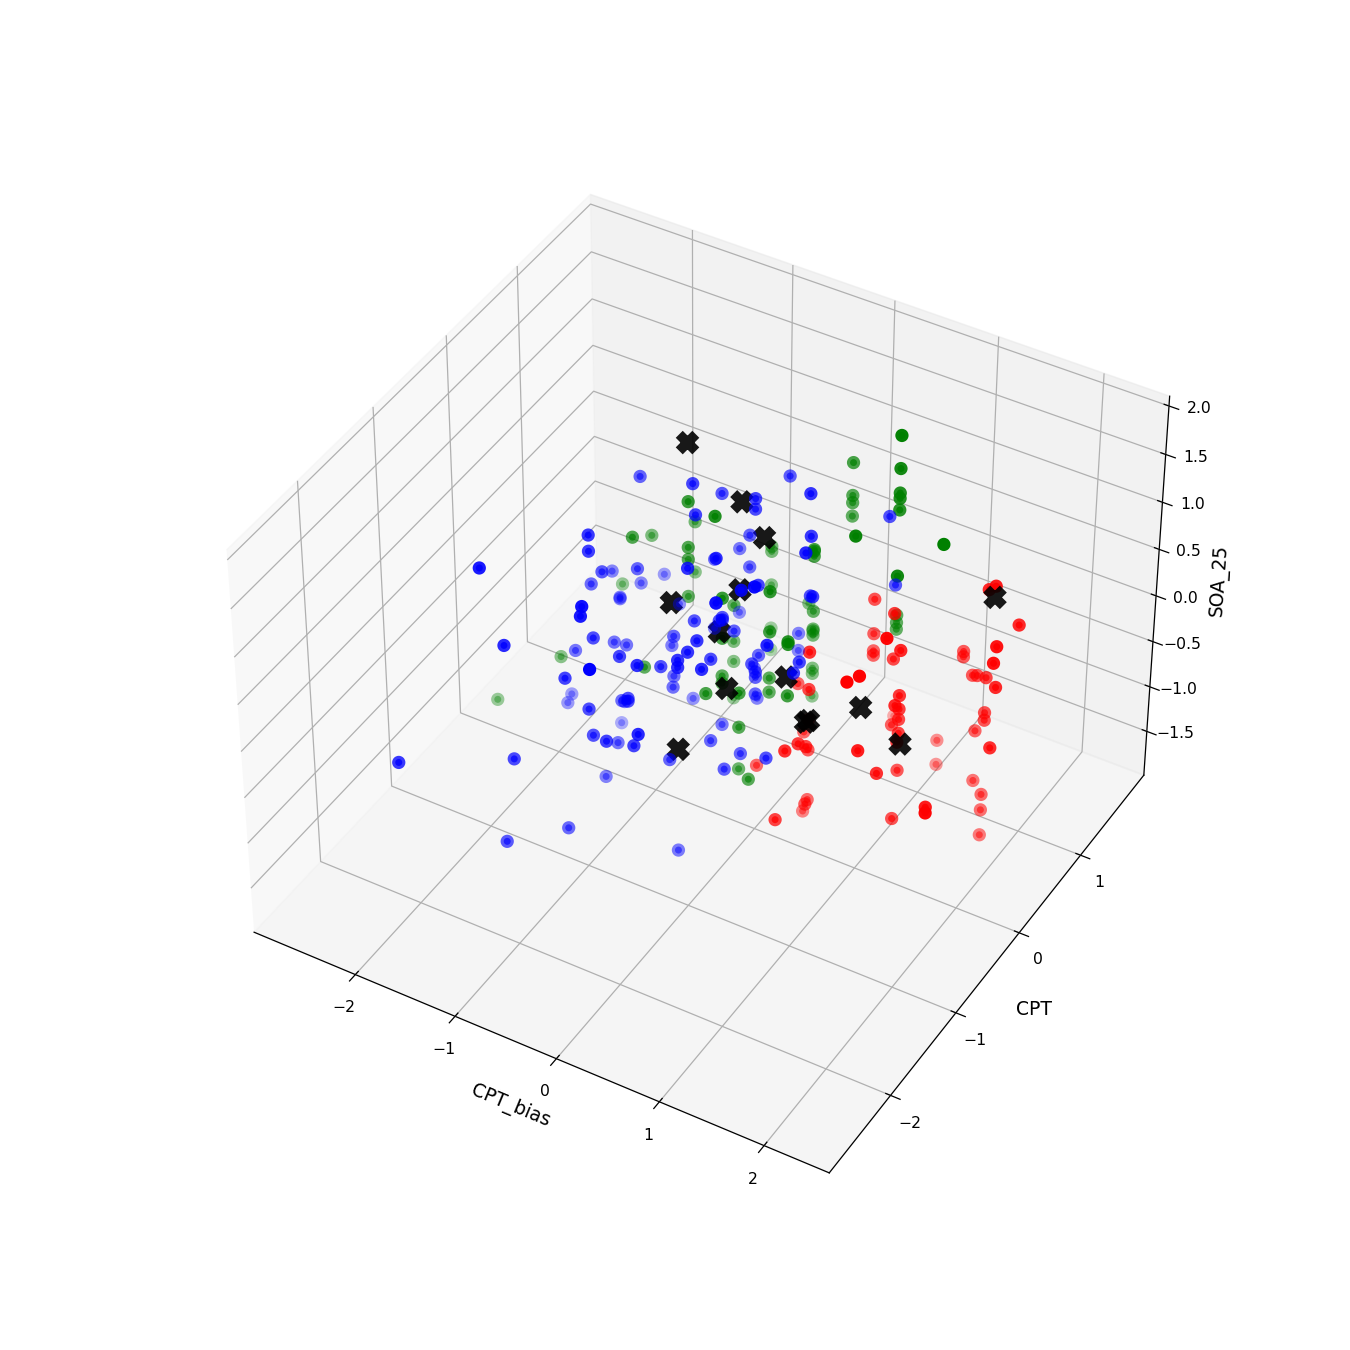

In [47]:
#Plot of the 'unstable' points, they are represented by a black cross in the 3D scatter plot
%matplotlib notebook
index_0=np.where(pred1==0)
index_1=np.where(pred1==1)
index_2=np.where(pred1==2)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.set_xlabel('CPT_bias',fontsize=12)
ax.set_zlabel('SOA_25',fontsize=12)
ax.set_ylabel('CPT',fontsize=12)
ax.scatter(X_res1[index_0,2],X_res1[index_0,1],X_res1[index_0,0],color='red',linewidth = 4)
ax.scatter(X_res1[index_1,2],X_res1[index_1,1],X_res1[index_1,0],color='blue',linewidth = 4)
ax.scatter(X_res1[index_2,2],X_res1[index_2,1],X_res1[index_2,0],color='green',linewidth = 4)
ax.scatter(X_res1[index_cl_change,3],X_res1[index_cl_change,1],X_res1[index_cl_change,0],color='black',linewidth = 15,marker='x',alpha=0.9)

### Cross validation

In [53]:
#Cross validation for the variables we selected previously
X_res1=X[:,[0,2,3,7]]
index_err,pred=cross_validation(X_res1,10,0.2)

Total of errors after running for the 8 folds : 15
Total of errors after running for the 8 folds : 12
Total of errors after running for the 8 folds : 11
Total of errors after running for the 8 folds : 10
Total of errors after running for the 8 folds : 9
Total of errors after running for the 8 folds : 14
Total of errors after running for the 8 folds : 15
Total of errors after running for the 8 folds : 15
Total of errors after running for the 8 folds : 11
Total of errors after running for the 8 folds : 15


In [17]:
#Cross validation to compare what happens with a different subset of variables
#This conforts us with the idea that the selected variables are the most relevant ones
#Black crosses on 3D plot show which data points got their label wrongly assigned
X_res1=X[:,[0,2,3,4,6,7]]
_,_=cross_validation(X_res1,10,0.15)

Total of errors after running for the 8 folds : 74
Total of errors after running for the 8 folds : 48
Total of errors after running for the 8 folds : 38
Total of errors after running for the 8 folds : 47
Total of errors after running for the 8 folds : 40
Total of errors after running for the 8 folds : 46
Total of errors after running for the 8 folds : 52
Total of errors after running for the 8 folds : 41
Total of errors after running for the 8 folds : 42
Total of errors after running for the 8 folds : 43


<IPython.core.display.Javascript object>


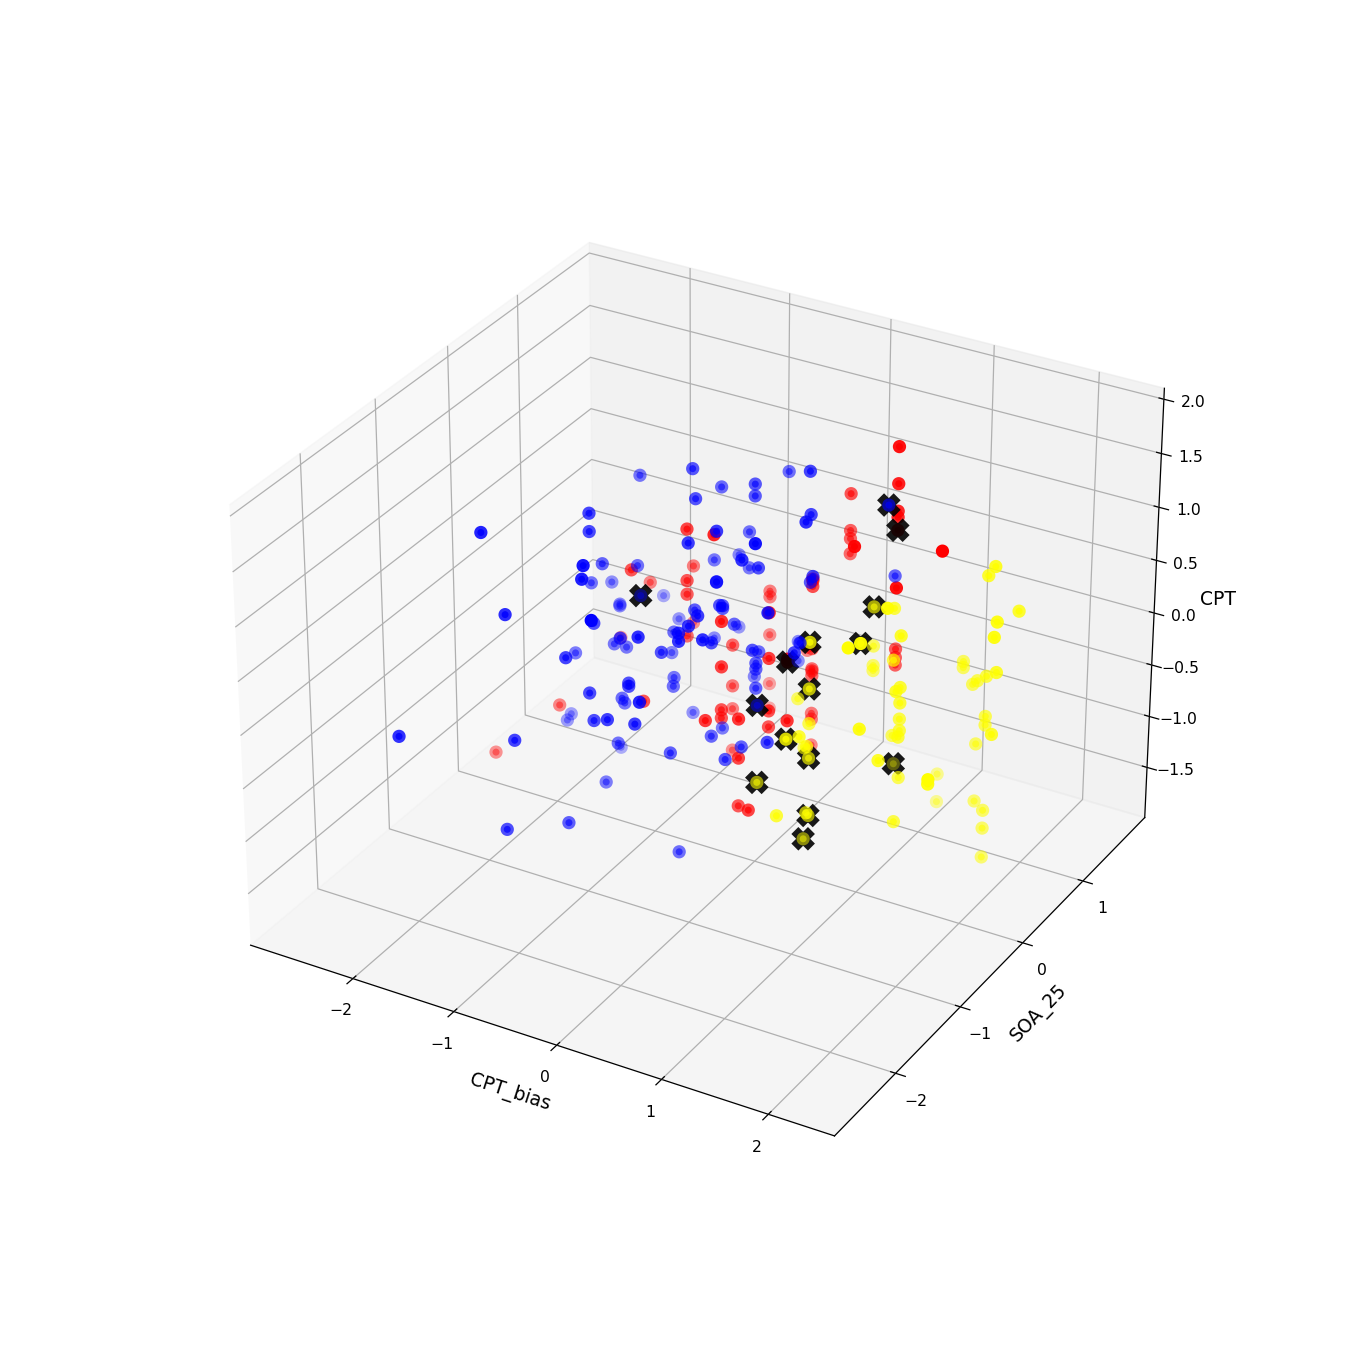

In [54]:
%matplotlib notebook
index_0=np.where(pred==0)
index_1=np.where(pred==1)
index_2=np.where(pred==2)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.set_xlabel('CPT_bias',fontsize=12)
ax.set_ylabel('SOA_25',fontsize=12)
ax.set_zlabel('CPT',fontsize=12)

ax.scatter(X_res1[index_0,2],X_res1[index_0,1],X_res1[index_0,0],color='red',linewidth = 4)
ax.scatter(X_res1[index_1,2],X_res1[index_1,1],X_res1[index_1,0],color='blue',linewidth = 4)
ax.scatter(X_res1[index_2,2],X_res1[index_2,1],X_res1[index_2,0],color='yellow',linewidth = 4)
ax.scatter(X_res1[index_err,2],X_res1[index_err,1],X_res1[index_err,0],color='black',linewidth = 15,marker='x',alpha=0.9)

### PCA

In [ ]:
## In this section, we use Principal Component Analysis in order to reduce the space dimension.

In [19]:
#SVD decomposition
u,s,v=np.linalg.svd(X)
v=v.T



<IPython.core.display.Javascript object>


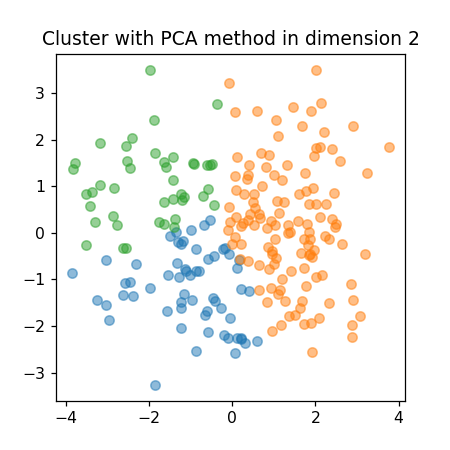

Text(0.5, 1.0, 'Cluster with PCA method in dimension 2')

In [44]:
#Plot with the PCA in a 2 dimension space
X_pca=X@v[:,0:2]
method_pca=Gaussian_Mixture(3,X_pca,0.21)
pred_pca=method_pca.predict(X_pca)
index_0=np.where(pred_pca==0)
index_1=np.where(pred_pca==1)
index_2=np.where(pred_pca==2)
fig = plt.figure(figsize=(4, 4))
plt.scatter(X_pca[index_0,0], X_pca[index_0,1],alpha=0.5)
plt.scatter(X_pca[index_1,0], X_pca[index_1,1],alpha=0.5)
plt.scatter(X_pca[index_2,0], X_pca[index_2,1],alpha=0.5)
plt.title('Cluster with PCA method in dimension 2')

<IPython.core.display.Javascript object>


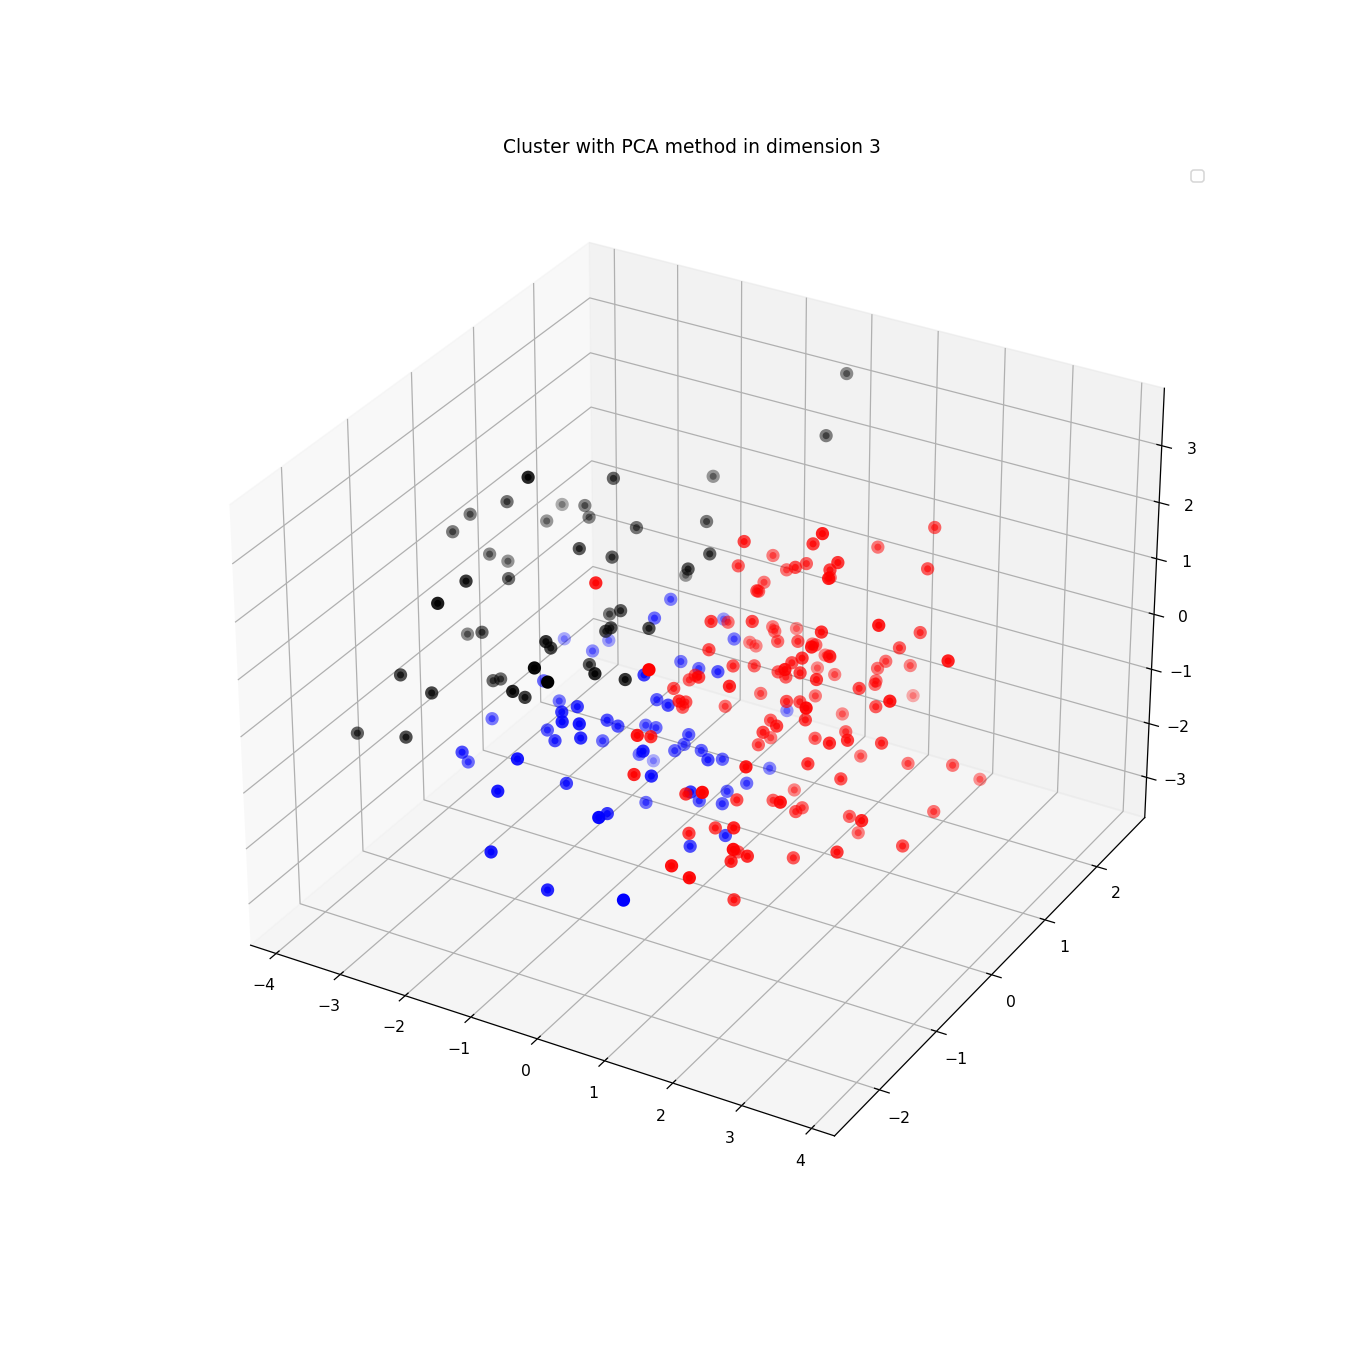

No handles with labels found to put in legend.


In [45]:
#Plot with the PCA in a 3 dimension space
X_pca=X@v[:,0:3]
method_pca=Gaussian_Mixture(3,X_pca,0.21)
pred_pca=method_pca.predict(X_pca)
%matplotlib notebook
index_0=np.where(pred_pca==0)
index_1=np.where(pred_pca==1)
index_2=np.where(pred_pca==2)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter(X_pca[index_0,0],X_pca[index_0,2],X_pca[index_0,1],color='black',linewidth = 4)
ax.scatter(X_pca[index_1,0],X_pca[index_1,2],X_pca[index_1,1],color='red',linewidth = 4)
ax.scatter(X_pca[index_2,0],X_pca[index_2,2],X_pca[index_2,1],color='blue',linewidth = 4)
plt.title('Cluster with PCA method in dimension 3')
plt.legend()


### Stability with PCA

In [55]:
#Projection in a 4 dimensions subspace
X_pca=X@v[:,0:4]
method_pca=Gaussian_Mixture(3,X_pca,0.21)
pred_pca=method_pca.predict(X_pca)
f,index_cl_change,pred_pca=stability2(200,3,X_pca,'EM')

<IPython.core.display.Javascript object>


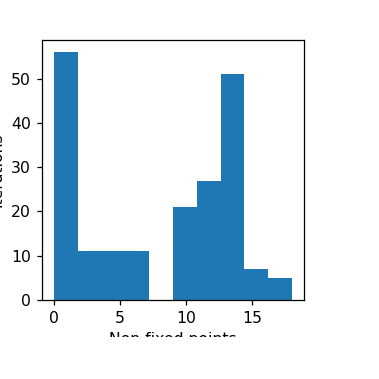

(array([56., 11., 11., 11.,  0., 21., 27., 51.,  7.,  5.]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <BarContainer object of 10 artists>)

In [56]:
fig = plt.figure(figsize=(3, 3))
plt.xlabel("Non fixed points")
plt.ylabel("Iterations")
plt.hist(f)


In [24]:
#plot the silhouette score for the PCA method
sklearn.metrics.silhouette_score(X_pca, pred_pca)

0.21326336734196322

<IPython.core.display.Javascript object>


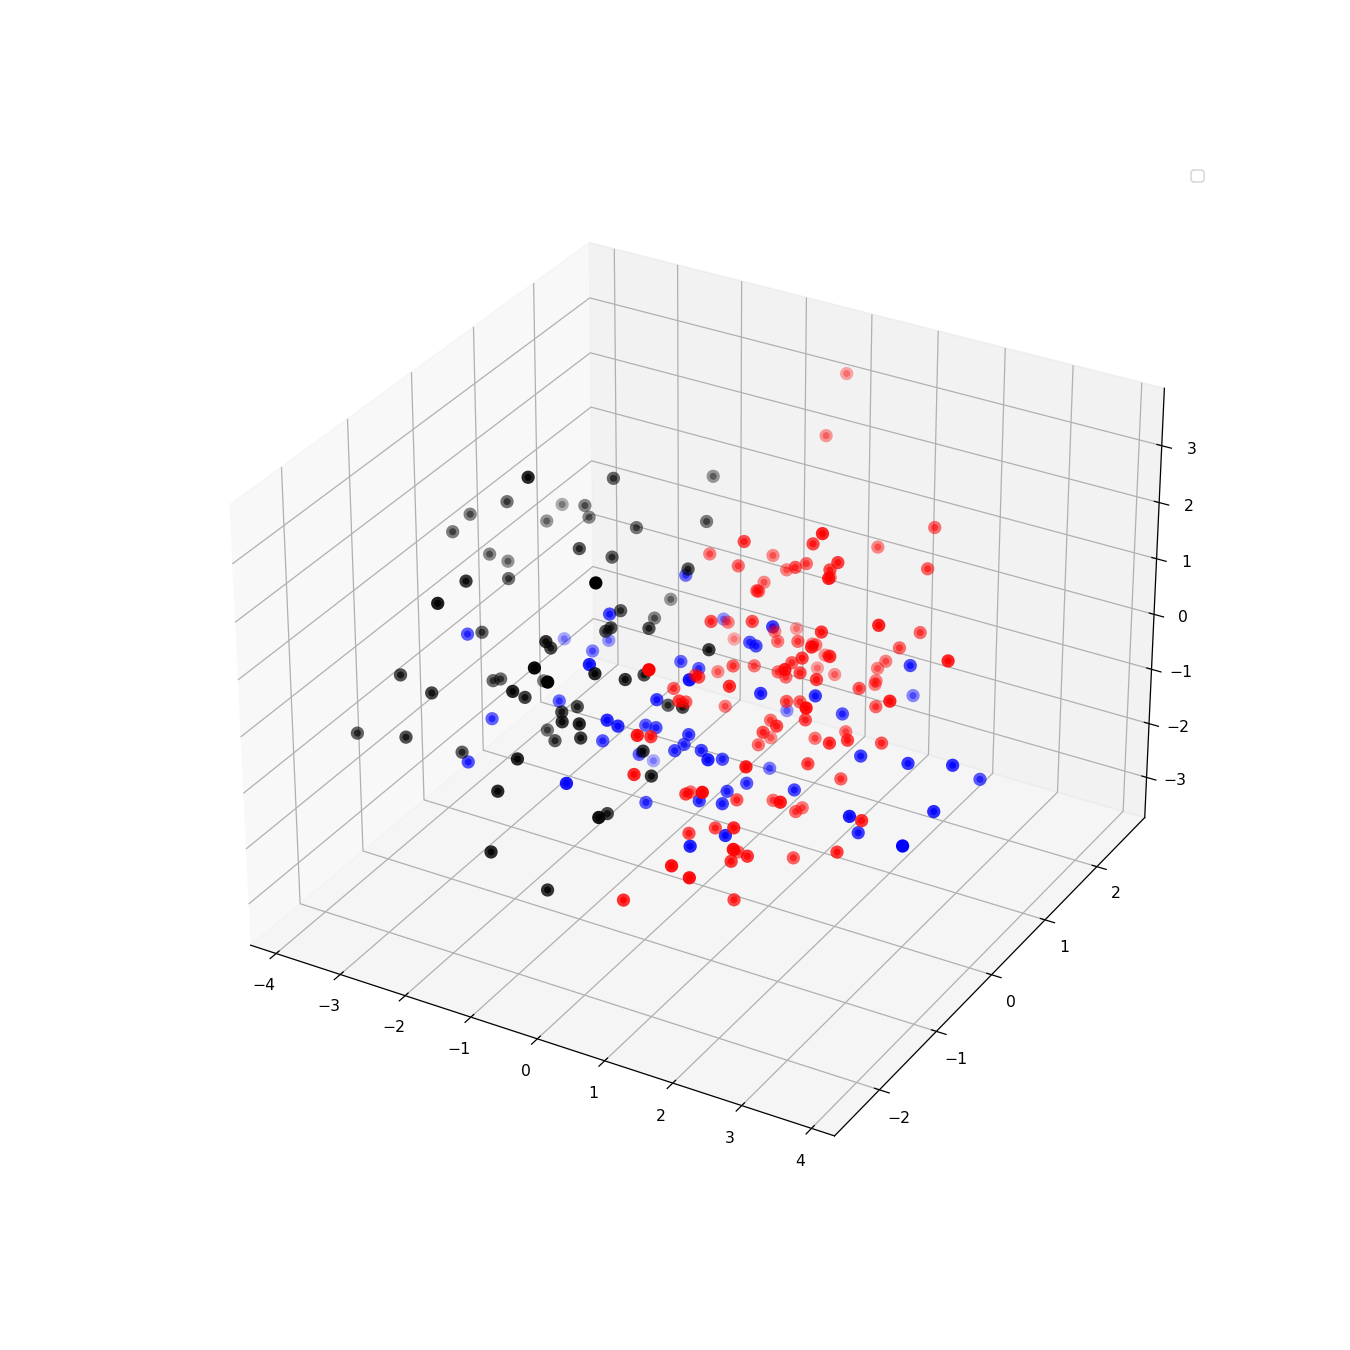

No handles with labels found to put in legend.


In [25]:

%matplotlib notebook
index_0=np.where(pred_pca==0)
index_1=np.where(pred_pca==1)
index_2=np.where(pred_pca==2)

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
ax.scatter(X_pca[index_0,0],X_pca[index_0,2],X_pca[index_0,1],color='black',linewidth = 4)
ax.scatter(X_pca[index_1,0],X_pca[index_1,2],X_pca[index_1,1],color='red',linewidth = 4)
ax.scatter(X_pca[index_2,0],X_pca[index_2,2],X_pca[index_2,1],color='blue',linewidth = 4)
plt.legend()


### Cross validation for PCA


In [26]:
index_err,pred_pca=cross_validation(X_pca,10,0.2)

Total of errors after running for the 8 folds : 23
Total of errors after running for the 8 folds : 18
Total of errors after running for the 8 folds : 18
Total of errors after running for the 8 folds : 29
Total of errors after running for the 8 folds : 20
Total of errors after running for the 8 folds : 17
Total of errors after running for the 8 folds : 17
Total of errors after running for the 8 folds : 23
Total of errors after running for the 8 folds : 21
Total of errors after running for the 8 folds : 29


### Anova and comparison of the different means

In [27]:
#Load the symptom data
from data_import import*
demo= pd.read_csv("demographics.csv",sep=',')
demo=demo.head(227)
all_symptom=[]
all_symptom_name=[]
all_symptom,all_symptom_name = data_symptom(demo,all_symptom,all_symptom_name)

In [28]:
from anova_ttest import*

In [29]:
'''
Print the different mean of the features in each cluster (for 'PCA METHOD')
'''
mean_features_label=[]
for i in range(np.shape(X)[1]):
    print("Mean for the features",i,calculate_mean_of_label(X[:,i],pred_pca))
    mean_features_label.append(calculate_mean_of_label(X[:,i],pred_pca))

Mean for the features 0 [-0.09454449073122893, -0.35330016124918895, 0.5834222462268184]
Mean for the features 1 [-0.13343232875194624, -0.4833459091578743, 0.7807415879854609]
Mean for the features 2 [0.09108818888649654, 0.830427378355088, -0.9934225740548639]
Mean for the features 3 [-0.022146949840470064, 0.43371822385042036, -0.1687023722785334]
Mean for the features 4 [-0.9142496583342965, 0.7799648923283686, 0.0286674504503359]
Mean for the features 5 [-0.6713206322175254, 0.724452703053644, 0.19741385109803478]
Mean for the features 6 [0.7221448812169851, -0.8916202888539526, -0.209338400041449]
Mean for the features 7 [0.5365323277242465, -0.5259402719195445, -0.08049532930987376]


In [30]:
'''
Print the different mean of the symptom in each cluster (for 'PCA METHOD')
'''

mean_symptom_label=[]
for i,symptom in enumerate(all_symptom):
    print("Mean for the symptom",all_symptom_name[i],calculate_mean_of_label(symptom,pred_pca))
    mean_symptom_label.append(calculate_mean_of_label(symptom,pred_pca))





Mean for the symptom illduration [12.591836734693878, 12.261194029850746, 11.790322580645162]
Mean for the symptom VisualAcuity [1.4571428571428573, 1.4432835820895524, 1.479032258064516]
Mean for the symptom SANS [11.408163265306122, 7.955223880597015, 12.14516129032258]
Mean for the symptom Affect [2.5510204081632653, 1.8805970149253732, 2.5806451612903225]
Mean for the symptom Alogie [2.4693877551020407, 1.671641791044776, 2.838709677419355]
Mean for the symptom Abulie [2.857142857142857, 1.5820895522388059, 2.629032258064516]
Mean for the symptom Anhedonie [2.6020408163265305, 2.1194029850746268, 2.5483870967741935]
Mean for the symptom Aufmerksamkeit [1.2959183673469388, 0.7611940298507462, 1.8387096774193548]
Mean for the symptom SAPS [9.89795918367347, 9.014925373134329, 11.225806451612904]
Mean for the symptom Halluzinationen [1.8979591836734695, 1.3880597014925373, 1.7419354838709677]
Mean for the symptom Wahnerleben [2.836734693877551, 3.1641791044776117, 3.0]
Mean for the sy

In [31]:

'''
Print the p-value of the anova for the symptom (we compare if the mean of each symptom is different in each cluster (for 'PCA METHOD')
'''
for i,symptom in enumerate(all_symptom):
    print("Anova for the symptom",all_symptom_name[i],symptom_anova(pred_pca,symptom)[1])



Anova for the symptom illduration 0.8434469547412301
Anova for the symptom VisualAcuity 0.8635957583750787
Anova for the symptom SANS 2.9204982246402143e-06
Anova for the symptom Affect 0.002158811239323965
Anova for the symptom Alogie 4.7596445242631666e-05
Anova for the symptom Abulie 1.4107592600316121e-07
Anova for the symptom Anhedonie 0.06659024211687255
Anova for the symptom Aufmerksamkeit 0.00016638382299041953
Anova for the symptom SAPS 0.084743404912527
Anova for the symptom Halluzinationen 0.17753932434677686
Anova for the symptom Wahnerleben 0.32109366170328996
Anova for the symptom Bizarres Verhalten 0.016830663607174785
Anova for the symptom Denkstorung 0.18549854309853278
Anova for the symptom CPZ nan
Anova for the symptom Handedness 0.4472608298205627


In [32]:
'''
Print the p-value of the anova for the features (we compare if the mean of each features is different in each cluster (for 'PCA METHOD')
'''

mean_symptom_label=[]
for i in range(np.shape(X)[1]) :
    print("Anova for the features",i,symptom_anova(pred,X[:,i])[1])
    mean_symptom_label.append(calculate_mean_of_label(symptom,pred_pca))


Anova for the features 0 3.87438182224893e-18
Anova for the features 1 3.3968978090552196e-09
Anova for the features 2 3.388261941490766e-45
Anova for the features 3 5.032882046006546e-41
Anova for the features 4 0.08806829251681147
Anova for the features 5 0.17470336599463232
Anova for the features 6 0.12428071489043982
Anova for the features 7 0.4591539501830034


### Print results with our  variables selection method

In [33]:
X_res1=X[:,[0,2,3,7]]
clf=Gaussian_Mixture(3,X_res1,0.22)
pred1=clf.predict(X_res1)

In [34]:
'''
Print the different means of the symptom in each cluster (for 'VARIABLE SELECTION METHOD')
'''

mean_symptom_label=[]
for i,symptom in enumerate(all_symptom):
    print("Mean for the symptom",all_symptom_name[i],calculate_mean_of_label(symptom,pred1))
    mean_symptom_label.append(calculate_mean_of_label(symptom,pred1))


Mean for the symptom illduration [13.940677966101696, 11.89423076923077, 11.359375]
Mean for the symptom VisualAcuity [1.455593220338983, 1.4655769230769233, 1.4515625]
Mean for the symptom SANS [10.135593220338983, 12.125, 8.515625]
Mean for the symptom Affect [2.3728813559322033, 2.6346153846153846, 1.90625]
Mean for the symptom Alogie [2.152542372881356, 2.8076923076923075, 1.734375]
Mean for the symptom Abulie [2.305084745762712, 2.6826923076923075, 2.09375]
Mean for the symptom Anhedonie [2.2711864406779663, 2.5384615384615383, 2.453125]
Mean for the symptom Aufmerksamkeit [1.271186440677966, 1.6634615384615385, 0.6875]
Mean for the symptom SAPS [10.186440677966102, 10.586538461538462, 8.875]
Mean for the symptom Halluzinationen [2.1864406779661016, 1.7211538461538463, 1.234375]
Mean for the symptom Wahnerleben [3.0338983050847457, 2.923076923076923, 3.015625]
Mean for the symptom Bizarres Verhalten [2.288135593220339, 2.4711538461538463, 1.984375]
Mean for the symptom Denkstorung

In [35]:
'''
Print the different mean of the features in each cluster (for 'VARIALBE SELECTION METHOD')
'''
mean_features_label=[]
for i in range(np.shape(X)[1]):
    print("Mean for the features",i,calculate_mean_of_label(X[:,i],pred1))

Mean for the features 0 [-0.30169734693952305, 0.5233627639822198, -0.5217793064689429]
Mean for the features 1 [-0.2777062383504037, 0.4889499966276229, -0.4925108947307607]
Mean for the features 2 [0.16031718257599617, -0.6849813180819703, 1.0117565715282364]
Mean for the features 3 [1.2992312310919916, -0.2797241518348963, -0.48647121892586326]
Mean for the features 4 [-0.04303796363812585, -0.3204494617821775, 0.004758548080567887]
Mean for the features 5 [0.05358762147172272, -0.1308657061674367, 0.08495205765525958]
Mean for the features 6 [-0.17019962915535955, 0.1440558569477694, -0.10761519998315511]
Mean for the features 7 [0.031568108295178234, 0.11615994335794239, -0.02487020339823462]


In [36]:
'''
Print the p-value of the anova for the symptom (we compare if the mean of each symptom is different in each cluster (for 'VARIALBE SELECTION METHOD')
'''
for i,symptom in enumerate(all_symptom):
    print("Anova for the symptom",all_symptom_name[i],symptom_anova(pred1,symptom)[1])



Anova for the symptom illduration 0.1956494450082058
Anova for the symptom VisualAcuity 0.9698506043925567
Anova for the symptom SANS 5.295791393077046e-05
Anova for the symptom Affect 0.0028448516127296776
Anova for the symptom Alogie 3.562525389104284e-05
Anova for the symptom Abulie 0.03999816244246973
Anova for the symptom Anhedonie 0.4912873789891077
Anova for the symptom Aufmerksamkeit 0.00015278271495646693
Anova for the symptom SAPS 0.15927434050862663
Anova for the symptom Halluzinationen 0.009411744859490626
Anova for the symptom Wahnerleben 0.8567983078181874
Anova for the symptom Bizarres Verhalten 0.09050127831402573
Anova for the symptom Denkstorung 0.48077084245416934
Anova for the symptom CPZ nan
Anova for the symptom Handedness 0.510190489616748


In [37]:
'''
Print the p-value of the anova for the features (we compare if the mean of each features is different in each cluster (for 'VARIALBE SELECTION METHOD')
'''

mean_symptom_label=[]
for i in range(np.shape(X)[1]) :
    print("Anova for the features",i,symptom_anova(pred1,X[:,i])[1])
    mean_symptom_label.append(calculate_mean_of_label(symptom,pred1))


Anova for the features 0 5.046779633228067e-18
Anova for the features 1 2.9023793689978874e-10
Anova for the features 2 9.825667000799193e-47
Anova for the features 3 2.0222309949048946e-41
Anova for the features 4 0.09732982505167743
Anova for the features 5 0.19214742644041913
Anova for the features 6 0.14492092184648858
Anova for the features 7 0.5486722470563927


### Print the different t-test

In [42]:
'''
Print the different t-test for pca method according to all symptom

'''
#if we want to print a=0 NOT otherwise
a=1
if a==0 :
    for i,symptom in enumerate(all_symptom):
        print("Mean for the symptom",all_symptom_name[i],t_test_symptome(pred_pca,symptom))



In [43]:
'''
Print the different t-test for pca method according to all symptom

'''
#if we want to print a=0 NOT otherwise
a=1
if a==0 :
    for i,symptom in enumerate(all_symptom):
        print("Mean for the symptom",all_symptom_name[i],t_test_symptome(pred1,symptom))


<IPython.core.display.Javascript object>


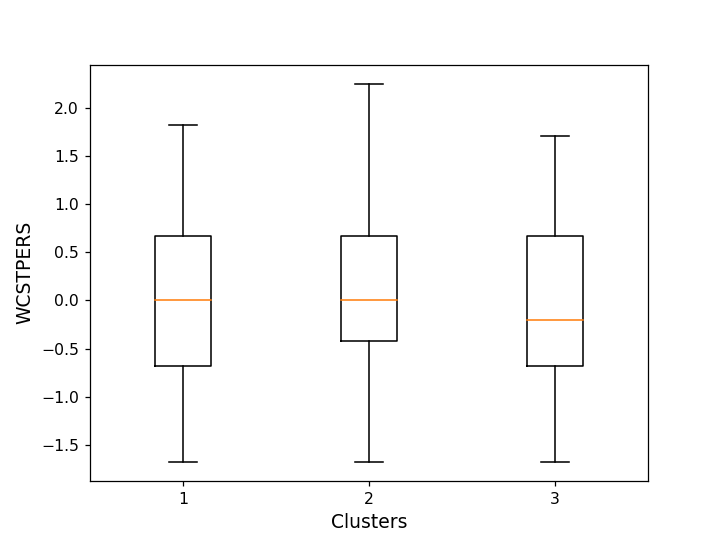

In [40]:
#Boxplot of the variable 7
X_res1=X[:,[0,2,3,7]]
clf=Gaussian_Mixture(3,X_res1,0.22)
pred1=clf.predict(X_res1)

index_0=np.where(pred1==0)
index_1=np.where(pred1==1)
index_2=np.where(pred1==2)
X_modify=[]

fig, ax = plt.subplots()
X_modify=[np.reshape(X_res1[index_0,3],(np.shape(index_0)[1],)),np.reshape(X_res1[index_1,3],(np.shape(index_1)[1],)),np.reshape(X_res1[index_2,3],(np.shape(index_2)[1],))]    
ax.set_xlabel('Clusters',fontsize=12)
ax.set_ylabel('WCSTPERS',fontsize=12)
ax.boxplot(X_modify)
plt.show()

<IPython.core.display.Javascript object>


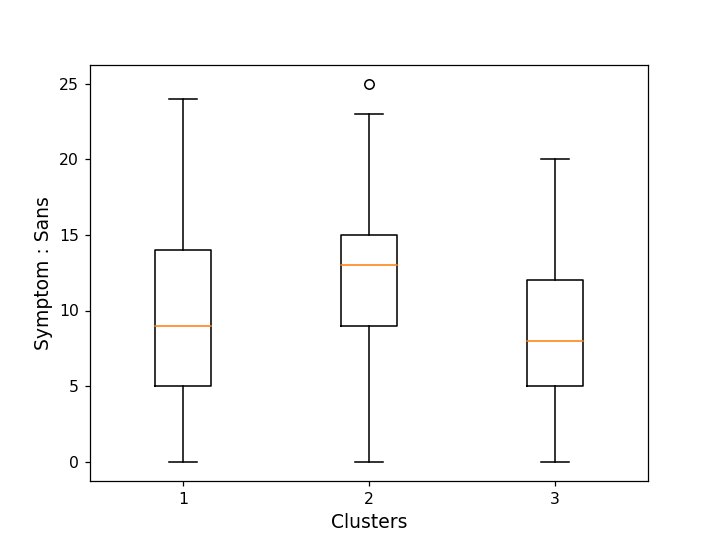

In [41]:
#Boxplot of the symptom sans

X_res1=X[:,[0,2,3,7]]
clf=Gaussian_Mixture(3,X_res1,0.22)
pred1=clf.predict(X_res1)

index_0=np.where(pred1==0)
index_1=np.where(pred1==1)
index_2=np.where(pred1==2)
X_modify=[]
sans_symptom=all_symptom[2]
fig, ax = plt.subplots()
X_modify=[np.reshape(sans_symptom[index_0],(np.shape(index_0)[1],)),np.reshape(sans_symptom[index_1],(np.shape(index_1)[1],)),np.reshape(sans_symptom[index_2],(np.shape(index_2)[1],))]    
ax.set_xlabel('Clusters',fontsize=12)
ax.set_ylabel('Symptom : Sans',fontsize=12)
ax.boxplot(X_modify)
plt.show()